## CNN VXL-Net - TFM Emilio Pomares Porras MUIA Alfonso X el Sabio, 2023-2024

### Sistema de visión artificial para manipulación robótica a tasas interactivas con arquitecturas basadas en UNet: VXL-Net

#### Artificial vision system for robotic manipulation at interactive framerates with UNet based architectures: VXL-Net

# ETAPA DE EVALUACIÓN - EVALUATION STAGE

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.quantization import fuse_modules
import torch.quantization
import torchvision.transforms as transforms
import torch.nn.functional as F

import os

import cv2

import numpy as np

import random

import time

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

checkpoint_dir = "../checkpoints"
checkpoint_fn = "model_checkpoint_running_mVoxelNet_v4_2_correct_rmisty-meadow-32_tl0.009472012519836426_tm9287_vm9287_256167.16s.pth" # Your checkpoint here
TRAIN_DATASET_PATH = "/Volumes/2TBDrive/robovision_train" # Point to your test data
TEST_DATASET_PATH = "/Volumes/2TBDrive/robovision_test" # Point to your test data

IMG_SIZE = 256
N_CHANNELS = 6
BATCH_SIZE = 32 # Let's stick to the classics

In [2]:
# We need the model definition here
def copy_inflate(input_tensor):
    """
    Inflates towards the 2nd axis by
    producing multiple copies of the
    0th-1st axis slice
    """
    # Get the shape of the input tensor
    batch_size, C, _, N = input_tensor.shape

    # Reshape the input tensor to add a singleton dimension at the end
    inflated_tensor = input_tensor.unsqueeze(-1)

    # Repeat the singleton dimension N times along the last axis
    inflated_tensor = inflated_tensor.expand(-1, -1, -1, -1, N)

    return inflated_tensor


class DoubleConv2D(nn.Module):
    """
    Double Convolution 2D
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv1(x)     
        x = self.bn1(x)     
        x = self.relu(x)       
        x = self.conv2(x)      
        x = self.bn2(x)     
        x = self.relu(x)       
        return x

        
class DoubleConv3D(nn.Module):
    """
    Double Convolution 3D
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class VoxelNet_v4(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet_v4, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps
        self.relu = nn.ReLU()
        self.mode = "occupancy"

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            #print(f" addinf out feature {feature}")
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        #print("We start with out_channels: ", out_channels)
        
        # Decoder
        for i in range(1,6):
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<5 else 3, stride=2 if i<5 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.final_conv_1 = nn.Conv3d(64, 32, kernel_size=1)
        self.final_conv_2 = nn.Conv3d(32, 16, kernel_size=1)
        self.final_conv_3 = nn.Conv3d(16, 4, kernel_size=1)
        self.final_conv_4 = nn.Conv3d(4, out_channels, kernel_size=1)

        self.pose_dense_1 = nn.Linear(2 ** (self.steps+4-1), 256)
        self.pose_dense_2 = nn.Linear(256, 64)
        self.pose_dense_3 = nn.Linear(64, 16)
        self.pose_dense_4 = nn.Linear(16, 7)

    def set_mode(mode):
        freeze_pose = True
        if mode=='occupancy':
            freeze_pose = True
        elif mode=='pose':
            freeze_pose = False
        else:
            raise ValueException("Unknown mode")
        # Freeze layer1 and layer2
        for param in self.encoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.decoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.residual_connections.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_1.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_2.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_3.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_4.parameters():
            param.requires_grad = freeze_pose
        for param in self.pose_dense_1.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_2.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_3.parameters():
            param.requires_grad = not freeze_pose
        for param in self.pose_dense_4.parameters():
            param.requires_grad = not freeze_pose

    def forward(self, x):
        
        encoder_outputs = []

        # Encoder
        for module in self.encoder:
            x = module(x)
            x = self.pool(x)
            encoder_outputs.append(x)
        
        if self.mode == "pose":
            x_pose = x[:,:,0,0]
            x_pose = self.pose_dense_1(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_2(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_3(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_4(x_pose)
            return x_pose
        
        x = x.unsqueeze(-1)
        
        # Decoder
        for i in range(1,6):
            residual_connection = encoder_outputs[-i]
            inflated_connection = copy_inflate(residual_connection)
            x = torch.cat([x, inflated_connection], dim=1)
            x = self.decoder[i-1](x)
        
        x = self.final_conv_1(x)
        x = self.relu(x)
        x = self.final_conv_2(x)
        x = self.relu(x)
        x = self.final_conv_3(x)
        x = self.relu(x)
        x = self.final_conv_4(x).squeeze(dim=1)

        return x

In [3]:
model = VoxelNet_v4(in_channels=6, out_channels=1, steps=8).to("cpu")

checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_fn))

# Load the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Let's make sure the model has loaded correctly

In [4]:
model

VoxelNet_v4(
  (encoder): ModuleList(
    (0): DoubleConv2D(
      (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DoubleConv2D(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DoubleConv2D(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05,

We need at least pytorch 1.3

In [5]:
print(f"torch version: {torch.__version__}")
assert (int(str(torch.__version__).split(".")[0])*100 + int(str(torch.__version__).split(".")[1]))>=103, "Please upgrade to pytorch ^1.3"

torch version: 2.0.0+cu117


We set the model into evaluation mode:

In [6]:
model.eval();

We then apply dynamic quantization. We could resort to static quantization if the model was not performant enough in our target platform

Save the quantized model to disk

In [7]:
import struct

def load_target_datapoint(file_path, dataset_path=""):
    # Define the format string for reading the binary data
    format_string = "<3f4f"  # 3 floats (position), 4 floats (quaternion)
    # Calculate the size of the bytes for occupation data
    occupation_size = 37 * 25 * 18
    format_string += str(occupation_size) + "s"  # Occupation data

    with open(os.path.join(dataset_path, file_path), "rb") as file:
        # Read the binary data
        data = file.read(struct.calcsize(format_string))
        # Unpack the binary data according to the format string
        unpacked_data = struct.unpack(format_string, data)

        # Extract position, rotation, and occupation data
        position = unpacked_data[:3]
        rotation = unpacked_data[3:7]
        # Convert occupation data to array of numbers
        occupation = struct.unpack(str(occupation_size) + "B", unpacked_data[7])

        return position, rotation, occupation
    
def load_stereo_image(index=0, 
                      dataset_path="./", 
                      model_size=(IMG_SIZE, IMG_SIZE), 
                      l_path=None, 
                      r_path=None,
                      plot=False
                     ):
    dx = -110
    dy = -6
    l_file = l_path if l_path is not None else os.path.join(dataset_path, f"{index}L.png")
    r_file = r_path if r_path is not None else os.path.join(dataset_path, f"{index}R.png")
    l_img = cv2.cvtColor(cv2.imread(l_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.warpAffine(l_img, np.float32([[1, 0, dx], [0, 1, dy]]), (l_img.shape[1], l_img.shape[0]))
    r_img = cv2.cvtColor(cv2.imread(r_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.resize(l_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    r_img = cv2.resize(r_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    blended_image = cv2.addWeighted(l_img, 0.5, r_img, 0.5, 0)
    
    if plot:
        # Plot the blended image
        plt.title(f"sample {index} ({model_size[0]}x{model_size[0]} 3+3 channel, aspect corrected)")
        plt.imshow(blended_image, aspect=1/1.4)
        
    return torch.tensor(l_img/255.0), torch.tensor(r_img/255.0)

In [8]:
def plot_3d(data, aspect='equal', double_axis=True, ax=None):
    """
    Plots a 3D grid of scalar-valued voxels.

    Parameters:
    data (numpy.array): data (len(data.shape) should be 3)
    aspect (str): Aspect ratio for the plot (default is 'equal')
    double_axis (bool): Whether to scale the tick labels by a factor of 2
    ax (matplotlib.axes._subplots.Axes3DSubplot, optional): The axis to plot on. 
                                                           If None, a new figure and axis are created.
    """

    def explode(data):
        size = np.array(data.shape) * 2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e

    def explode_2(data):
        size = np.array(data.shape) * 2
        size[3] = data.shape[3]
        data_e = np.zeros((size[0] - 1, size[1] - 1, size[2] - 1, data.shape[3]), dtype=data.dtype)
        data_e[::2, ::2, ::2, :] = data
        return data_e

    filled = data
    colors = np.zeros(filled.shape + (4,))
    colors[..., 3] = filled  # Use tensor values for the alpha channel
    colors[..., :3] = plt.cm.viridis(filled)[..., :3]  # Assign colors using the viridis colormap

    # Upscale the above voxel image, leaving gaps
    filled_2 = explode(filled)
    colors_2 = explode_2(colors)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.05
    y[:, 0::2, :] += 0.05
    z[:, :, 0::2] += 0.05
    x[1::2, :, :] += 0.95
    y[:, 1::2, :] += 0.95
    z[:, :, 1::2] += 0.95

    # Create a new figure and axis only if ax is None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

    ax.voxels(x, y, z, filled_2, facecolors=colors_2)
    ax.set_aspect(aspect)

    if double_axis:
        # Scale the tick labels by a factor of 2
        xticks = ax.get_xticks()
        yticks = ax.get_yticks()
        zticks = ax.get_zticks()
    
        # Set the tick positions (using FixedLocator)
        ax.xaxis.set_major_locator(FixedLocator(xticks))
        ax.yaxis.set_major_locator(FixedLocator(yticks))
        ax.zaxis.set_major_locator(FixedLocator(zticks))
    
        # Now set the tick labels
        ax.set_xticklabels(np.round(xticks * 2, 2))
        ax.set_yticklabels(np.round(yticks * 2, 2))
        ax.set_zticklabels(np.round(zticks * 2, 2))

In [9]:
def make_model_input(l, r, permute=True):
    """Creates a tensor input datapoint to be fed into the model
    from l and r images
    Parameters:
    - l: left image
    - r: right image
    - permute (bool): apply permutation
    Returns:
    torch.tensor
    """
    if permute:
        assert l.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        assert r.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        lr = torch.cat([l, r], dim=2).permute(2,0,1).float()
    else:
        assert l.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        assert r.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        lr = torch.cat([l, r], dim=0).float()
    return lr

In [10]:
def get_padded_size(data, N):
    """
    Calculates padding sizes for F.pad so that each dimension is a multiple of N
    """
    n_dim = len(data.shape)
    dims = []
    for dim in range(n_dim):
        l = data.shape[dim]
        needed = ((N-(l-(l//N)*N))%N)
        needed_low = needed//2
        needed_high = needed-needed_low
        dims.append(needed_low)
        dims.append(needed_high)
    return tuple(dims[::-1])

def permute_target_tensor(t):
    return torch.flip(t, dims=[2]).permute(2, 0, 1)

def unpermute_target_tensor(t):
    return torch.flip(t.permute(1, 2, 0), dims=[2])

def crop_output(t):
    return t[6:6+37, 12:12+25, 15:15+18]

def expand_output(t):
    return F.pad(t, get_padded_size(np.zeros(t.shape), 48))

In [11]:
class CustomDataLoader(Dataset):
    """Class to load data from files in disk and convert
    them to tensors on the fly"""
    def __init__(self, data_dir, transform=None, additional_param=None):
        self.data_dir = data_dir
        self.transform = transform
        self.l_img_list = []
        self.r_img_list = []
        self.gt_list = []
        self.additional_param = additional_param
        for file in sorted(os.listdir(data_dir)):
            if file.endswith("L.png"):
                self.l_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("R.png"):
                self.r_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("T.bin"):
                self.gt_list.append(os.path.join(data_dir, file))
        
    def __len__(self):
        return len(self.gt_list)

    def __getitem__(self, idx):        
        l, r = load_stereo_image(l_path=self.l_img_list[idx], r_path=self.r_img_list[idx]);
        t, q, o = load_target_datapoint(self.gt_list[idx])

        # Apply transformations if specified
        if self.transform:
            l = self.transform(l)
            r = self.transform(r)

        l = l.permute(2, 0, 1)
        r = r.permute(2, 0, 1)

        augment_contrast=self.additional_param['contrast'] if (self.additional_param is not None and 'contrast' in self.additional_param) else 0
        augment_saturation=self.additional_param['saturation'] if (self.additional_param is not None and 'saturation' in self.additional_param) else 0
        augment_brightness=self.additional_param['brightness'] if (self.additional_param is not None and 'brightness' in self.additional_param) else 0
        augment_hue=self.additional_param['hue'] if (self.additional_param is not None and 'hue' in self.additional_param) else 0
        augment_noise=self.additional_param['noise'] if (self.additional_param is not None and 'noise' in self.additional_param) else 0

        # Augment each image separately, as l and r cameras are independent

        #l = transforms.functional.adjust_brightness(l, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        #l = transforms.functional.adjust_contrast(l, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        #l = transforms.functional.adjust_saturation(l, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        #l = transforms.functional.adjust_hue(l, (random.random() - 0.5) * 2 * augment_hue)
        #noise = np.random.normal(0, augment_noise, l.shape).astype(np.float32)
        #l = l + noise
        #l = torch.clip(l, 0, 1)

        #r = transforms.functional.adjust_brightness(r, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        #r = transforms.functional.adjust_contrast(r, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        #r = transforms.functional.adjust_saturation(r, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        #r = transforms.functional.adjust_hue(r, (random.random() - 0.5) * 2 * augment_hue)
        #noise = np.random.normal(0, augment_noise, r.shape).astype(np.float32)
        #r = r + noise
        #r = torch.clip(r, 0, 1)
        X = make_model_input(l, r, permute=False)

            
        occupation = torch.tensor(np.array(o, dtype='float32').reshape(37,25,18))
        occupation = expand_output(occupation)
        y = permute_target_tensor(occupation)

        return X, y

In [12]:
aug_params = {
    'contrast': 0.2,
    'brightness': 0.2,
    'saturation': 0.2,
    'hue': 0.2,
    'noise': 0.02
}

TEST_DATASET_PATH = "/Volumes/2TBDrive/REAL_SCENES/OUT_OF_DISTRIBUTION"

train_dataloader = CustomDataLoader(TRAIN_DATASET_PATH, additional_param=aug_params)
train_loader = DataLoader(train_dataloader, batch_size=BATCH_SIZE)

test_dataloader = CustomDataLoader(TEST_DATASET_PATH, additional_param=aug_params)
test_loader = DataLoader(test_dataloader, batch_size=BATCH_SIZE)

test_batch = None
for batch in test_loader:
    test_batch = batch
    break

In [13]:
test_dataloader = CustomDataLoader(TEST_DATASET_PATH)#, additional_param=aug_params)
test_loader = DataLoader(test_dataloader, batch_size=2)

for batch in test_loader:
        X = batch[0].to(device)
        y = batch[1].to(device)
        X_gpu = X.to("cuda:0", copy=True)
        print(X.shape)
        print(y.shape)
        plt.imshow(X[idx,0])
        break

NameError: name 'device' is not defined

torch.Size([2, 6, 256, 256])
torch.Size([2, 48, 48, 48])
torch.Size([37, 25, 18])


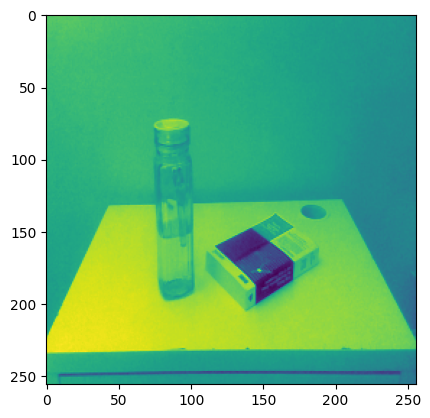

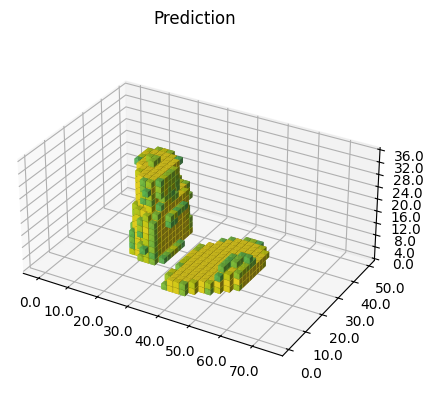

In [14]:
device = "cpu"
torch.set_num_threads(24)
th = nn.Threshold(0.5, 0)
with torch.no_grad():
    idx = 1
    model.eval()
    for batch in test_loader:
        X = batch[0].to(device)
        y = batch[1].to(device)
        X_gpu = X.to("cuda:0", copy=True)
        print(X.shape)
        print(y.shape)
        plt.imshow(X[idx,0])
        #start_time_quant = time.perf_counter() # PERF
        #pred = model_quantized(X_gpu[idx:idx+1])
        #end_time_quant = time.perf_counter() # PERF
        #execution_time_quant = end_time_quant - start_time_quant # PERF
        start_time = time.perf_counter() # PERF
        pred = model(X[idx:idx+1])
        end_time = time.perf_counter() # PERF
        execution_time = end_time - start_time # PERF
        #print(f"Original model inference time: {execution_time*1000}ms  -vs-  Quantized model inference time: {execution_time_quant*1000}ms")
        occ = crop_output(unpermute_target_tensor(torch.sigmoid(pred)[0]))
        occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
        occ = (occ > 0.75) * occ # th
        print(occ.shape)
        
        # Create a figure with 2 subplots with 3d projection arranged horizontally
        #fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 5))
        
        plot_3d(occ.detach().numpy())
        plt.title("Prediction")
        
        #plot_3d(crop_output(unpermute_target_tensor(y[idx])).detach().numpy(), ax=axs[1])
        #axs[1].set_title("Ground truth")
        
        # Show the plot
        plt.show()
        
        break

In [15]:
count_parameters(model)

NameError: name 'count_parameters' is not defined

In [204]:
count_parameters(model_quantized)

(90017664, 360070656, '90M', '343MB')